In [ ]:
import csv
from pathlib import Path 
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from keras.preprocessing import sequence
import os 

import tensorflow as tf

from keras import backend
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, Reshape
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


In [ ]:
max_features = 20000
maxlen = 100

Ytrain=[]
trainx=[]
Ytest=[]
testx=[]
print("loading the data...")
with open('/home/jovyan/work/out5.csv',errors='ignore') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = '\t')
    for row in csv_reader:
        if csv_reader.line_num < 170001:
            Ytrain.append(int(row[0].split('/')[0]))
            trainx.append(row[1])
        elif csv_reader.line_num < 190001:
            Ytest.append(int(row[0].split('/')[0]))
            testx.append(row[1]) 
        else:
            break    

#194869


print("data loaded, processing data...")


# create the tokenizer
tok= Tokenizer(num_words=max_features, lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ', char_level=False, oov_token=None, document_count=0)
# fit the tokenizer on the documents
tok.fit_on_texts(trainx)
# summarize what was learned
#print(train.word_counts)
#print(train.document_count)
#print(train.word_index)
#print(train.word_docs)
# integer encode documents
Xtrain = tok.texts_to_sequences(trainx)

Xtest = tok.texts_to_sequences(testx)




#Xtrain, y_train = shuffle(Xtrain, Ytrain, random_state=0)
#Xtest, y_test = shuffle(Xtest, Ytest, random_state=0)


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Ytrain)
encoded_Ytrain = encoder.transform(Ytrain)
encoded_Ytest = encoder.transform(Ytest)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_Ytrain)
y_test = np_utils.to_categorical(encoded_Ytest)

encoder_length = len(y_train[0])
print("length of one hot enconding  ", encoder_length)

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(Xtrain, maxlen=maxlen)
x_test = sequence.pad_sequences(Xtest, maxlen=maxlen)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

loading the data...
data loaded, processing data...
length of one hot enconding   10
Pad sequences (samples x time)
x_train shape: (169990, 100)
x_test shape: (20000, 100)


In [ ]:
# Embedding
embedding_size = 128

# Training
batch_size = 30
epochs = 2


print('Data processede, Build model...')


model = Sequential()
#model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dense(20, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(encoder_length,activation='softmax'))
#model.add(Reshape((embedding_size, ), input_shape=(1,embedding_size))) 

# Compile model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	

print('Model built, Training model...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


Data processede, Build model...
Model built, Training model...
Train on 169990 samples, validate on 20000 samples
Epoch 1/2
169990/169990 [==============================] - 15s 88us/step - loss: 28.0670 - accuracy: 0.2628 - val_loss: 2.0693 - val_accuracy: 0.2698
Epoch 2/2
20000/20000 [==============================] - 1s 29us/step
Test score: 2.0561424517035483
Test accuracy: 0.26980000734329224


In [ ]:
#https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

from keras.layers import Flatten
# Embedding
embedding_size = 128

# Training
batch_size = 30
epochs = 2


print('Data processede, Build model...')


model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(encoder_length,activation='softmax'))
#model.add(Reshape((embedding_size, ), input_shape=(1,embedding_size))) 

# Compile model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	

print('Model built, Training model...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


Data processede, Build model...
Model built, Training model...
/opt/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
Train on 169990 samples, validate on 20000 samples
Epoch 1/2
169990/169990 [==============================] - 250s 1ms/step - loss: 1.5542 - accuracy: 0.4185 - val_loss: 1.5479 - val_accuracy: 0.4129
Epoch 2/2
20000/20000 [==============================] - 1s 65us/step
Test score: 1.7209984447062014
Test accuracy: 0.39375001192092896


In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping

embedding_size = 128


model = Sequential()
model.add(Embedding(max_features,embedding_size, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(encoder_length, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
#overfitting so next time run it on only 3 epochs
batch_size = 64


history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])



score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


/opt/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
Train on 152991 samples, validate on 16999 samples
Epoch 1/5
152991/152991 [==============================] - 819s 5ms/step - loss: 1.6303 - accuracy: 0.4043 - val_loss: 1.5780 - val_accuracy: 0.4202
Epoch 2/5
152991/152991 [==============================] - 1115s 7ms/step - loss: 1.4282 - accuracy: 0.4673 - val_loss: 1.5182 - val_accuracy: 0.4306
Epoch 3/5
152991/152991 [==============================] - 924s 6ms/step - loss: 1.3367 - accuracy: 0.4980 - val_loss: 1.4953 - val_accuracy: 0.4379
Epoch 4/5
152991/152991 [==============================] - 808s 5ms/step - loss: 1.2575 - accuracy: 0.5265 - val_loss: 1.5284 - val_accuracy: 0.4345
Epoch 5/5
20000/20000 [==============================] - 26s 

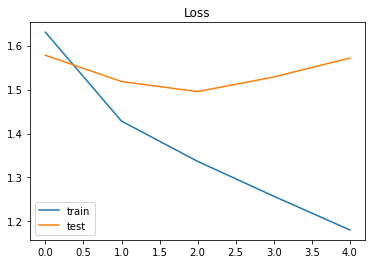

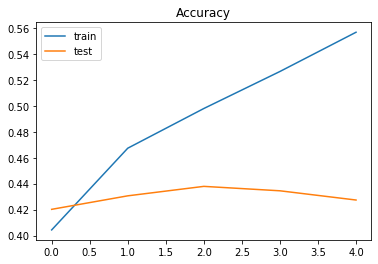

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.figure(2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()


plt.show();



In [ ]:
new_review = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tok.texts_to_sequences(new_review)
padded = sequence.pad_sequences(seq, maxlen=maxlen)
pred = model.predict(padded)
labels = [1,2,3,4,5,6,7,8,9,10]
print(pred, labels[np.argmax(pred)])

[[0.00705979 0.0040823  0.00353269 0.00221548 0.00179916 0.00976076
  0.03205789 0.5186592  0.12064838 0.30018443]] 8


In [ ]:
new_review = ['Oh my God ! This movie was awesome, just perfect, I could not think of anything better. All the scenes were just so nice to watch']
seq = tok.texts_to_sequences(new_review)
padded = sequence.pad_sequences(seq, maxlen=maxlen)
pred = model.predict(padded)
labels = [1,2,3,4,5,6,7,8,9,10]
print(pred, labels[np.argmax(pred)])

[[0.00640092 0.00107702 0.0013447  0.00126647 0.00255085 0.00807769
  0.02050057 0.06919801 0.09867894 0.79090476]] 10


In [ ]:
new_review = ['What a stupid movie. I really did not like it, it was very bad and the director did the worse job of his whole career']
seq = tok.texts_to_sequences(new_review)
padded = sequence.pad_sequences(seq, maxlen=maxlen)
pred = model.predict(padded)
labels = [1,2,3,4,5,6,7,8,9,10]
print(pred, labels[np.argmax(pred)])

[[0.6037918  0.20389019 0.11198179 0.05177733 0.01516991 0.00564018
  0.00372884 0.00182091 0.00083739 0.00136171]] 1


In [ ]:
new_review = ["I am quite mitigated, I don't know what to think of that movie. It was good and bad at the same time. Surprising and predictible."]
seq = tok.texts_to_sequences(new_review)
padded = sequence.pad_sequences(seq, maxlen=maxlen)
pred = model.predict(padded)
labels = [1,2,3,4,5,6,7,8,9,10]
print(pred, labels[np.argmax(pred)])

[[0.07752717 0.04462324 0.05434432 0.04027456 0.07001341 0.09462134
  0.1546827  0.19310789 0.12259126 0.14821424]] 8


In [ ]:
new_review = ['bad bad good good good']
seq = tok.texts_to_sequences(new_review)
padded = sequence.pad_sequences(seq, maxlen=maxlen)
pred = model.predict(padded)
labels = [1,2,3,4,5,6,7,8,9,10]
print(pred, labels[np.argmax(pred)])

[[0.41003612 0.10809951 0.10943709 0.02144562 0.0260176  0.0756944
  0.11727473 0.09445654 0.01327505 0.02426337]] 1


In [ ]:
new_review = ['good good good bad bad']
seq = tok.texts_to_sequences(new_review)
padded = sequence.pad_sequences(seq, maxlen=maxlen)
pred = model.predict(padded)
labels = [1,2,3,4,5,6,7,8,9,10]
print(pred, labels[np.argmax(pred)])

[[0.19719304 0.07071788 0.09243896 0.04212261 0.04405927 0.20197491
  0.20271413 0.10356182 0.0148425  0.03037498]] 7


In [ ]:
new_review = ['bad good good good good good ']
seq = tok.texts_to_sequences(new_review)
padded = sequence.pad_sequences(seq, maxlen=maxlen)
pred = model.predict(padded)
labels = [1,2,3,4,5,6,7,8,9,10]
print(pred, labels[np.argmax(pred)])

[[0.01290021 0.00459269 0.01082098 0.0041751  0.01271386 0.07368619
  0.37135518 0.44244608 0.02891242 0.03839726]] 8


In [ ]:
new_review = [" By the following morning, hardly anyone in Little Hangleton doubted that Frank Bryce had killed the Riddles.But over in the neighboring town of Great Hangleton, in the dark and dingy police station, Frank was stubbornly repeating, again and again, that he was innocent, and that the only person he had seen near the house on the day of the Riddles deaths had been a teenage boy, a stranger, dark-haired and pale.  Nobody else in the village had seen any such boy, and the police were quite sure Frank had invented him.Then, just when things were looking very serious for Frank, the report on the Riddles bodies came back and changed everything. "]
seq = tok.texts_to_sequences(new_review)
padded = sequence.pad_sequences(seq, maxlen=maxlen)
pred = model.predict(padded)
labels = [1,2,3,4,5,6,7,8,9,10]
print(pred, labels[np.argmax(pred)])

[[0.03233257 0.00613175 0.00915738 0.00398829 0.00700682 0.01261707
  0.02008836 0.05279134 0.13395464 0.7219318 ]] 10


In [ ]:
def angela_accuracy(correct_label,predicted_label):
    return_vector=[]
    for i in range(keras.backend.int_shape(correct_label)[1]):
        if abs(correct_label[i]-predicted_label[i])<2:
            return_vector.append(1)
        else:
            return_vector.append(0)
    return return_vector

import keras.backend as K

def angela_accuracy2(y_true,y_pred):
    zer_tensor = K.ones_like(y_true)
    return K.less_equal(K.abs(y_true-y_pred),zer_tensor)


	

    

def angela_accuracythebestone(y_true,y_pred):
    print(type(y_true))
    y_true_numpy = y_true.numpy()
    y_pred_numpy = y_pred.numpy()
    result = (abs(y_true_numpy - y_pred_numpy)<1).sum()
    return tf.constant(result)
    


In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.metrics import top_k_categorical_accuracy


embedding_size = 100

def top2_acc(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

model = Sequential()
model.add(Embedding(max_features,embedding_size, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(encoder_length, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 3
batch_size = 64

#Ytrain = [x-1 for x in Ytrain]
#Ytest = [x-1 for x in Ytest]


history2 = model.fit(x_train, Ytrain, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])



score, acc = model.evaluate(x_test, Ytest, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


/opt/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
Train on 152991 samples, validate on 16999 samples
Epoch 1/3
152991/152991 [==============================] - 737s 5ms/step - loss: 1.6359 - accuracy: 0.4021 - sparse_categorical_accuracy: 0.4021 - val_loss: 1.5688 - val_accuracy: 0.4123 - val_sparse_categorical_accuracy: 0.4123
Epoch 2/3
152991/152991 [==============================] - 728s 5ms/step - loss: 1.4353 - accuracy: 0.4637 - sparse_categorical_accuracy: 0.4637 - val_loss: 1.5092 - val_accuracy: 0.4251 - val_sparse_categorical_accuracy: 0.4251
Epoch 3/3
20000/20000 [==============================] - 24s 1ms/step


ValueError: too many values to unpack (expected 2)

In [ ]:
new_review = ['This movie is like a gold nugget on a pile of shit that Hollywood movies are']
seq = tok.texts_to_sequences(new_review)
padded = sequence.pad_sequences(seq, maxlen=maxlen)
pred = model.predict(padded)
labels = [1,2,3,4,5,6,7,8,9,10]
print(pred, labels[np.argmax(pred)])

[[0.4250978  0.07531857 0.05404088 0.02239358 0.01854195 0.0111109
  0.0275068  0.06593528 0.07648055 0.22357361]] 1


In [ ]:
a = tf.constant([1,3])
b = tf.constant([2,4])
c = a.numpy()
d = b.numpy()
j = c+d
g=(0<d)
h=g.sum()
print(h)

2


AttributeError: module 'tensorflow' has no attribute 'Session'

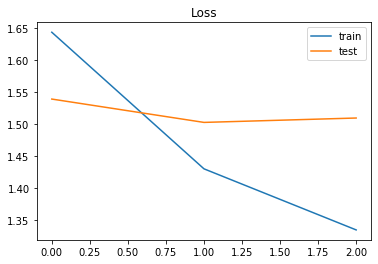

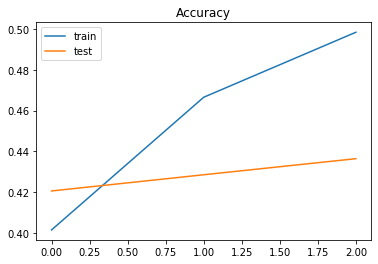

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.title('Loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()

plt.figure(2)
plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='test')
plt.legend()

3<
plt.show();



In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping

embedding_size = 128


model = Sequential()
model.add(Embedding(max_features,embedding_size, input_length=maxlen))
#model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(encoder_length, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
#overfitting so next time run it on only 3 epochs
batch_size = 64


history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])



score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

/opt/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
Train on 152991 samples, validate on 16999 samples
Epoch 1/5
  1088/152991 [..............................] - ETA: 15:03 - loss: 2.2531 - accuracy: 0.2647

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.figure(2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()


plt.show();
